In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, confusion_matrix
import math
import seaborn as sns

In [265]:
teamname = "Santos"

matches = pd.read_csv("spi_matches.csv")
if(teamname == "all") :
    team_matches = matches
else :
    team_matches = matches[np.logical_or(matches['team1'] == teamname, matches['team2'] == teamname)]
team_matches_data = team_matches.loc[:, ['date', 'team1', 'team2', 'score1', 'score2', 'prob1', 'prob2', 'importance1', 'importance2', 'spi1', 'spi2']]

In [266]:
for label, row in team_matches_data.iterrows() :
    print(str(row["date"]) + " : " + str(row["team1"]) + " " + str(row["score1"])[0] + "x"  + str(row["score2"])[0] + " " + str(row["team2"]))
    if(row['team1'] == teamname) :
        team_matches_data.loc[label, "goals_team"] = row['score1']
        team_matches_data.loc[label, "goals_adv"] = row['score2']
        team_matches_data.loc[label, "place"] = 0.0
        team_matches_data.loc[label, "prob_team"] = row['prob1']
        team_matches_data.loc[label, "spi_team"] = row['spi1']
        team_matches_data.loc[label, "spi_adv"] = row['spi2']
        team_matches_data.loc[label, "spi_dif"] = row['spi1'] - row['spi2']
        if(math.isnan(row['importance1'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else : 
            team_matches_data.loc[label, "importance_team"] = row['importance1']
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_adv"] = 0.0
    else :
        team_matches_data.loc[label, "goals_team"] = row['score2']
        team_matches_data.loc[label, "goals_adv"] = row['score1']
        team_matches_data.loc[label, "place"] = 1.0
        team_matches_data.loc[label, "prob_team"] = row['prob2']
        team_matches_data.loc[label, "spi_team"] = row['spi2']
        team_matches_data.loc[label, "spi_adv"] = row['spi1']
        team_matches_data.loc[label, "spi_dif"] = row['spi2'] - row['spi1']
        if(math.isnan(row['importance2'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else :
            team_matches_data.loc[label, "importance_team"] = row['importance2']
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_adv"] = 0.0

2017-05-14 : Fluminense 3x2 Santos
2017-05-20 : Santos 1x0 Coritiba
2017-05-28 : Santos 0x1 Cruzeiro
2017-06-03 : Corinthians 2x0 Santos
2017-06-07 : Santos 1x0 Botafogo
2017-06-11 : Atlético Paranaense 0x2 Santos
2017-06-14 : Santos 1x0 Palmeiras
2017-06-17 : Santos 0x0 Ponte Preta
2017-06-21 : Vítoria 0x2 Santos
2017-06-24 : Santos 0x1 Sport Recife
2017-07-01 : Atlético Goianiense 1x1 Santos
2017-07-09 : Santos 3x2 São Paulo
2017-07-12 : Atletico Mineiro 0x1 Santos
2017-07-16 : Vasco da Gama 0x0 Santos
2017-07-19 : Santos 1x0 Chapecoense AF
2017-07-23 : Santos 3x0 Bahía
2017-07-30 : Grêmio 1x1 Santos
2017-08-02 : Santos 3x2 Flamengo
2017-08-06 : Avaí 0x0 Santos
2017-08-14 : Santos 0x0 Fluminense
2017-08-20 : Coritiba 0x0 Santos
2017-08-27 : Cruzeiro 1x1 Santos
2017-09-10 : Santos 2x0 Corinthians
2017-09-16 : Botafogo 2x0 Santos
2017-09-23 : Santos 1x0 Atlético Paranaense
2017-09-30 : Palmeiras 0x1 Santos
2017-10-12 : Ponte Preta 1x1 Santos
2017-10-16 : Santos 2x2 Vítoria
2017-10-19 :

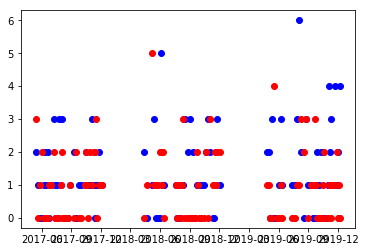

<Figure size 432x288 with 0 Axes>

In [267]:
team_matches_data.loc[:, "datetimeobj"] = team_matches_data.loc[:, "date"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))

plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_team'], xdate = True, ydate = False, color = 'blue')
plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_adv'], xdate = True, ydate = False, color = 'red')
plt.show()
plt.clf()

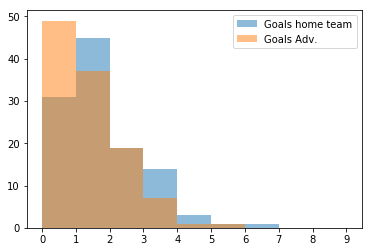

<Figure size 432x288 with 0 Axes>

In [268]:
plt.hist(team_matches_data['goals_team'], bins = range(10), alpha=0.5, label='Goals home team')
plt.hist(team_matches_data['goals_adv'], bins = range(10), alpha=0.5, label='Goals Adv.')
plt.legend(loc='upper right')
plt.xticks(range(10))
plt.show()
plt.clf()

# Training kNeighbors to predict goal numbers

Empty DataFrame
Columns: [date, team1, team2, score1, score2, prob1, prob2, importance1, importance2, spi1, spi2, goals_team, goals_adv, place, prob_team, spi_team, spi_adv, spi_dif, importance_team, datetimeobj]
Index: []
Predicted scores = 
[2. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.]


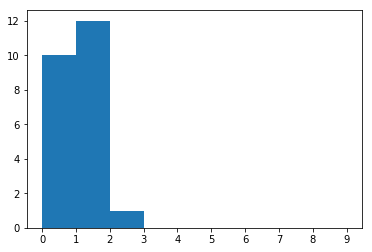


Precision of model = 
0.30434782608695654

Confusion Matrix: 
[[2 4 2 1 1]
 [4 5 1 2 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.29      0.20      0.24        10
        1.0       0.56      0.42      0.48        12
        2.0       0.00      0.00      0.00         1
        3.0       0.00      0.00      0.00         0
        5.0       0.00      0.00      0.00         0

avg / total       0.41      0.30      0.35        23



C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<Figure size 432x288 with 0 Axes>

In [269]:
team_done_matches = team_matches_data[team_matches_data['datetimeobj'] < datetime.datetime.now() - datetime.timedelta(days=1)]
team_predict = team_done_matches[['goals_team','prob_team', 'importance_team', 'spi_team', 'spi_adv', 'place', 'spi_dif']]

df1 = team_done_matches[team_predict.isna().any(axis=1)]
print(df1)

X = team_predict.drop('goals_team', axis=1).values
y = team_predict['goals_team'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
print("Predicted scores = ") 
print(knn.predict(X_test))
plt.hist(knn.predict(X_test), bins = range(10), alpha=1, label='Number of goals')
plt.xticks(range(10))
plt.show()
plt.clf()
print("\nPrecision of model = ") 
print(knn.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(knn.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(knn.predict(X_test), y_test))

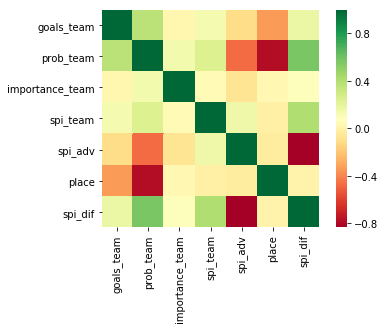

In [270]:
ax = sns.heatmap(team_predict.corr(), square=True, cmap='RdYlGn')
plt.show()

# Trying linear regression to predict scores

0.13913837805905804


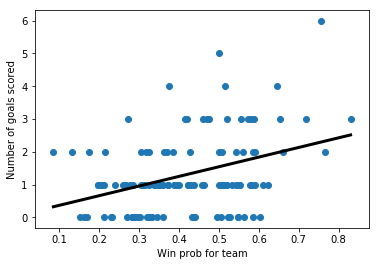

R^2: 0.0719446536946019
Root Mean Squared Error: 1.2124982257535193
[-0.26427031  0.18166192 -0.09421164  0.20446645  0.18733531]


<Figure size 432x288 with 0 Axes>

In [271]:
reg = LinearRegression()

X = team_predict['prob_team'].values.reshape(-1,1)
y = team_predict['goals_team'].values.reshape(-1,1)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg.fit(X, y)
result = reg.predict(prediction_space)
print(reg.score(X,y))

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Win prob for team")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)

0.03022275556447029


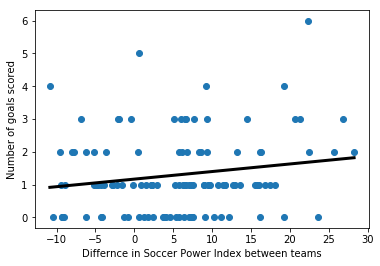

R^2: -0.07442678234905031
Root Mean Squared Error: 1.3046156562766242
[-0.21918318 -0.00638006  0.04586602  0.01240853  0.04277842]


<Figure size 432x288 with 0 Axes>

In [275]:
reg2 = LinearRegression()

X = team_predict['spi_dif'].values.reshape(-1,1)
y = team_predict['goals_team'].values.reshape(-1,1)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg2.fit(X, y)
result = reg2.predict(prediction_space)
print(reg2.score(X,y))

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Differnce in Soccer Power Index between teams")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)
print("R^2: {}".format(reg2.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)


Predictions

[0.93269231 1.27644231 0.20612981 0.62019231 0.62019231 0.98640325
 1.76081731 1.66706731 1.05769231 1.28767278 1.13581731 0.18269231
 1.82331731 1.09284856 0.87019231 0.80769231 1.05769231 0.79206731
 1.76862981 0.70612981 1.07331731 2.18269231 0.50300481]

Score

-0.0987721324157218

Coeficients

[ 4.37756587e-01 -1.39696465e-04 -1.11999474e+13  1.11999474e+13
 -6.98948597e-01  1.11999474e+13]
-1.6610576923076923


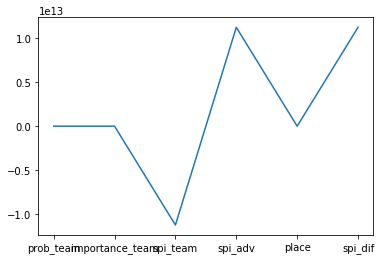

<Figure size 432x288 with 0 Axes>

In [276]:
reg_all = LinearRegression()

X = team_predict.drop('goals_team', axis = 1).values
y = team_predict['goals_team'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)
print("\nPredictions\n")
print(y_pred)
print("\nScore\n")
print(reg_all.score(X_test, y_test))
print("\nCoeficients\n")
print(reg_all.coef_)
print(reg_all.intercept_)

plt.plot(team_predict.drop('goals_team', axis = 1).columns, reg_all.coef_)
plt.show()
plt.clf()
